 1. PROCESS CAPABILITY ANALYSIS (Cp, Cpk)
Current Mean: 38.03g (Target: 27.5g)
Standard Deviation: 1.57g
Cp (Variation): 0.53
Cpk (Centering): -1.70
-> CONCLUSION: A negative Cpk indicates the mean is completely outside the specification limits. Massive product giveaway.

 2. NORMALITY TEST (D'Agostino's K-squared)
P-value: 3.8344e-01
-> RESULT: Data follows a normal distribution.

 3. HYPOTHESIS TESTING: ANOVA (Does Shift Affect Weight?)
ANOVA P-value: 7.4266e-33
-> CONCLUSION: Null hypothesis (H0) rejected. There are significant differences in weight depending on the shift.

 4. TUKEY HSD TEST (Identifying the root cause)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj  lower   upper  reject
-------------------------------------------------------
afternoon morning  -0.7031   0.0 -0.9432  -0.463   True
afternoon   night  -1.2803   0.0 -1.5204 -1.0402   True
  morning   night  -0.5772   0.0 -0.8173 -0.3371   True
--------------------------------

/var/folders/g7/cgmbtmzn2lj6h_4h9l71s1hc0000gn/T/ipykernel_1800/2941393980.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Shift', y='Weight_g', order=['morning', 'afternoon', 'night'], palette='muted', ax=axes[1])


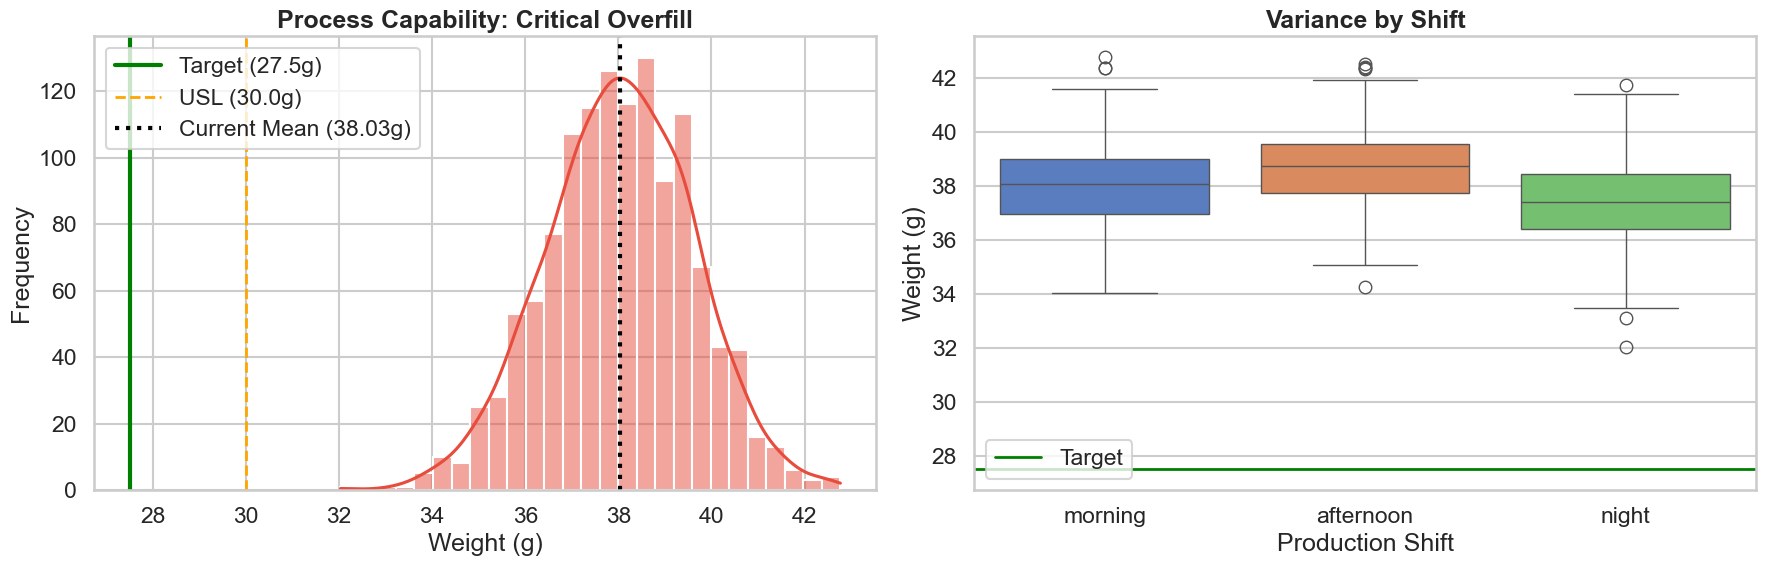

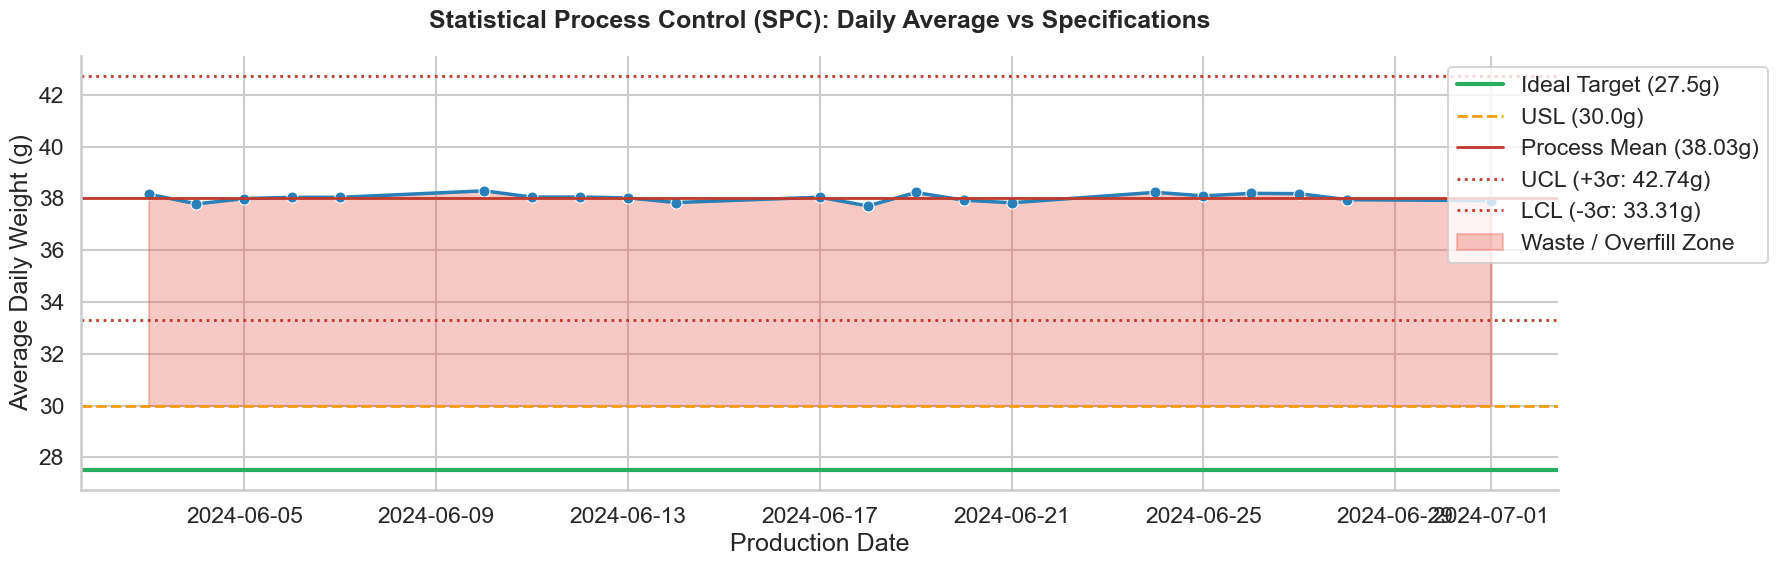

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Visual configuration
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 7)

# 1. Load Data
df = pd.read_csv('../data/Muestreo_PT_V2.csv')
df.rename(columns={'Fecha': 'Date', 'Turno': 'Shift', 'Peso (g)': 'Weight_g'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

# Translate shift names to English for plots and analysis
df['Shift'] = df['Shift'].replace({'mañana': 'morning', 'tarde': 'afternoon', 'noche': 'night'})

TARGET = 27.5
LSL = 25.0
USL = 30.0

print("="*50)
print(" 1. PROCESS CAPABILITY ANALYSIS (Cp, Cpk)")
print("="*50)
mu = df['Weight_g'].mean()
sigma = df['Weight_g'].std()
Cp = (USL - LSL) / (6 * sigma)
Cpk = min((USL - mu) / (3 * sigma), (mu - LSL) / (3 * sigma))

print(f"Current Mean: {mu:.2f}g (Target: {TARGET}g)")
print(f"Standard Deviation: {sigma:.2f}g")
print(f"Cp (Variation): {Cp:.2f}")
print(f"Cpk (Centering): {Cpk:.2f}")
print("-> CONCLUSION: A negative Cpk indicates the mean is completely outside the specification limits. Massive product giveaway.\n")

print("="*50)
print(" 2. NORMALITY TEST (D'Agostino's K-squared)")
print("="*50)
stat_norm, p_norm = stats.normaltest(df['Weight_g'])
print(f"P-value: {p_norm:.4e}")
if p_norm < 0.05:
    print("-> RESULT: Data is NOT perfectly normal (common in out-of-control processes).")
else:
    print("-> RESULT: Data follows a normal distribution.")

print("\n" + "="*50)
print(" 3. HYPOTHESIS TESTING: ANOVA (Does Shift Affect Weight?)")
print("="*50)
morning = df[df['Shift'] == 'morning']['Weight_g']
afternoon = df[df['Shift'] == 'afternoon']['Weight_g']
night = df[df['Shift'] == 'night']['Weight_g']

f_stat, p_anova = stats.f_oneway(morning, afternoon, night)
print(f"ANOVA P-value: {p_anova:.4e}")
if p_anova < 0.05:
    print("-> CONCLUSION: Null hypothesis (H0) rejected. There are significant differences in weight depending on the shift.")
    
    print("\n" + "="*50)
    print(" 4. TUKEY HSD TEST (Identifying the root cause)")
    print("="*50)
    tukey = pairwise_tukeyhsd(endog=df['Weight_g'], groups=df['Shift'], alpha=0.05)
    print(tukey)
    print("\n-> FINAL CONCLUSION: The Tukey test scientifically confirms the 'afternoon' shift is statistically heavier than the rest, validating the temperature-driven viscosity drop hypothesis.")

# ==========================================
# 5. MANDATORY VISUALIZATIONS
# ==========================================
# --- FIGURE 1: Histogram & Boxplot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Process Capability Histogram
sns.histplot(data=df, x='Weight_g', kde=True, ax=axes[0], color='#e74c3c')
axes[0].axvline(TARGET, color='green', lw=3, label=f'Target ({TARGET}g)')
axes[0].axvline(USL, color='orange', ls='--', lw=2, label=f'USL ({USL}g)')
axes[0].axvline(mu, color='black', ls=':', lw=3, label=f'Current Mean ({mu:.2f}g)')
axes[0].set_title('Process Capability: Critical Overfill', fontweight='bold')
axes[0].set_xlabel('Weight (g)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot 2: Boxplot by Shift (Visual Tukey)
sns.boxplot(data=df, x='Shift', y='Weight_g', order=['morning', 'afternoon', 'night'], palette='muted', ax=axes[1])
axes[1].axhline(TARGET, color='green', lw=2, label='Target')
axes[1].set_title('Variance by Shift', fontweight='bold')
axes[1].set_xlabel('Production Shift')
axes[1].set_ylabel('Weight (g)')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- FIGURE 2: Statistical Process Control (SPC) X-bar Chart ---
plt.figure(figsize=(18, 6))

# Calculate natural control limits of the machine (Mean +- 3 Standard Deviations)
UCL = mu + (3 * sigma)
LCL = mu - (3 * sigma)

# Group by day to get the daily average weight
df_daily = df.groupby('Date')['Weight_g'].mean().reset_index()

# Plot the daily trend line
sns.lineplot(data=df_daily, x='Date', y='Weight_g', marker='o', color='#2980b9', linewidth=2.5, markersize=8)

# Add Business Limits (Specifications)
plt.axhline(TARGET, color='#27ae60', lw=3, label=f'Ideal Target ({TARGET}g)')
plt.axhline(USL, color='#f39c12', ls='--', lw=2, label=f'USL ({USL}g)')

# Add Process Limits (What the machine is actually doing)
plt.axhline(mu, color='#c0392b', ls='-', lw=2, label=f'Process Mean ({mu:.2f}g)')
plt.axhline(UCL, color='#c0392b', ls=':', lw=2, label=f'UCL (+3σ: {UCL:.2f}g)')
plt.axhline(LCL, color='#c0392b', ls=':', lw=2, label=f'LCL (-3σ: {LCL:.2f}g)')

# Shade the red area to evidence that the process is out of specification (USL)
plt.fill_between(df_daily['Date'], USL, df_daily['Weight_g'], where=(df_daily['Weight_g'] > USL), 
                 interpolate=True, color='#e74c3c', alpha=0.3, label='Waste / Overfill Zone')

plt.title('Statistical Process Control (SPC): Daily Average vs Specifications', fontweight='bold', pad=20)
plt.xlabel('Production Date')
plt.ylabel('Average Daily Weight (g)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
sns.despine()

plt.tight_layout()
plt.show()